Loading data...
Data loaded successfully with 5830 rows and 27 columns

Data summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5830 entries, 0 to 5829
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   UMC report ID                    5830 non-null   int64  
 1   Country of primary source        5830 non-null   object 
 2   Reporter qualification           5830 non-null   object 
 3   Sex                              5830 non-null   object 
 4   Age/Years                        5830 non-null   float64
 5   Serious                          5314 non-null   object 
 6   Seriousness criteria             5830 non-null   object 
 7   Reported medication              5830 non-null   object 
 8   Indication                       5830 non-null   object 
 9   Dose                             2504 non-null   float64
 10  Dose unit                        2502 non-null   object 
 

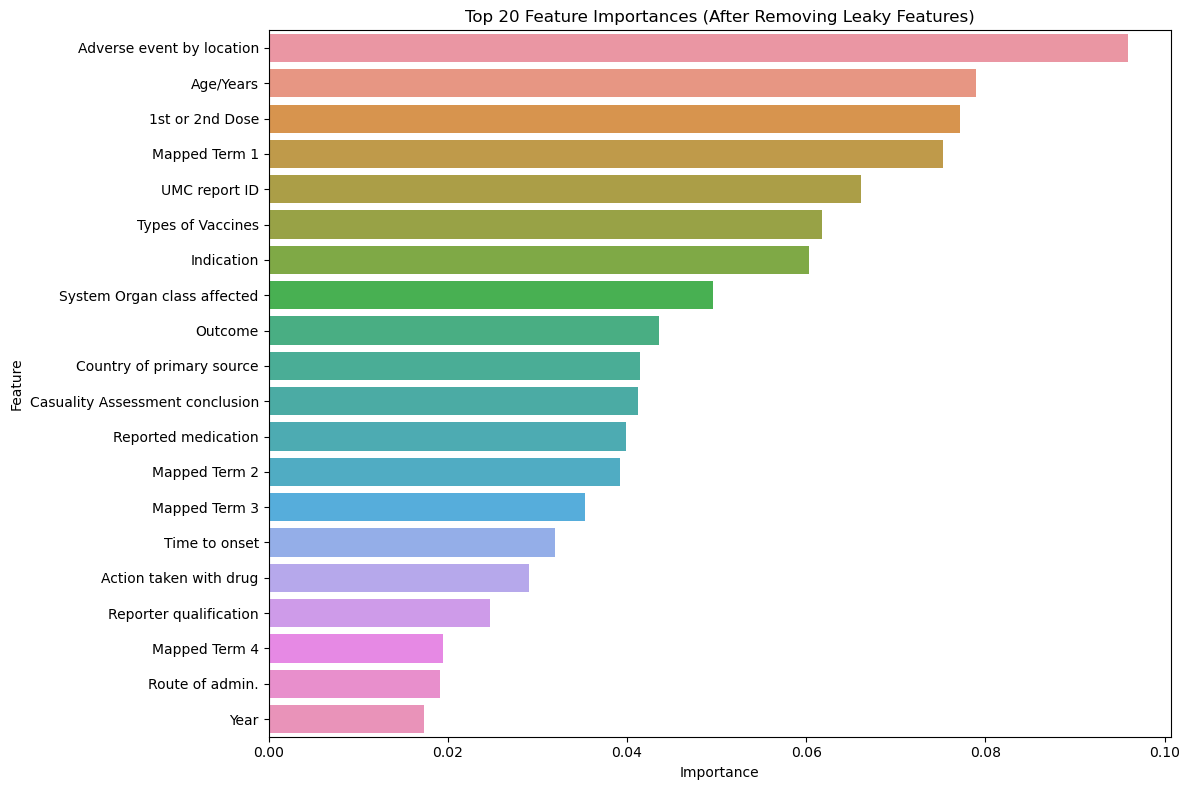


Selected 12 features: ['UMC report ID', 'Country of primary source', 'Age/Years', 'Reported medication', 'Indication', 'Outcome', 'Casuality Assessment conclusion', '1st or 2nd Dose', 'Types of Vaccines', 'Adverse event by location', 'System Organ class affected', 'Mapped Term 1']

Applying SMOTE to balance classes...
Original encoded class distribution:
Class 0: 3022 samples
Class 1: 6 samples
Class 2: 1170 samples
Class 3: 466 samples

After SMOTE, encoded class distribution:
Class 0 (Mild): 3022 samples
Class 1 (Moderate): 3022 samples
Class 2 (Severe): 3022 samples
Class 3 (Unreported): 3022 samples

========== MODEL TRAINING AND EVALUATION ==========

Training multi-class classification models...

===== Evaluating Random Forest =====
5-Fold CV Accuracy: 0.9433 ± 0.0032
Test Accuracy: 0.8568

Classification Report:
              precision    recall  f1-score   support

        Mild       0.88      0.90      0.89       756
    Moderate       0.00      0.00      0.00         1
     

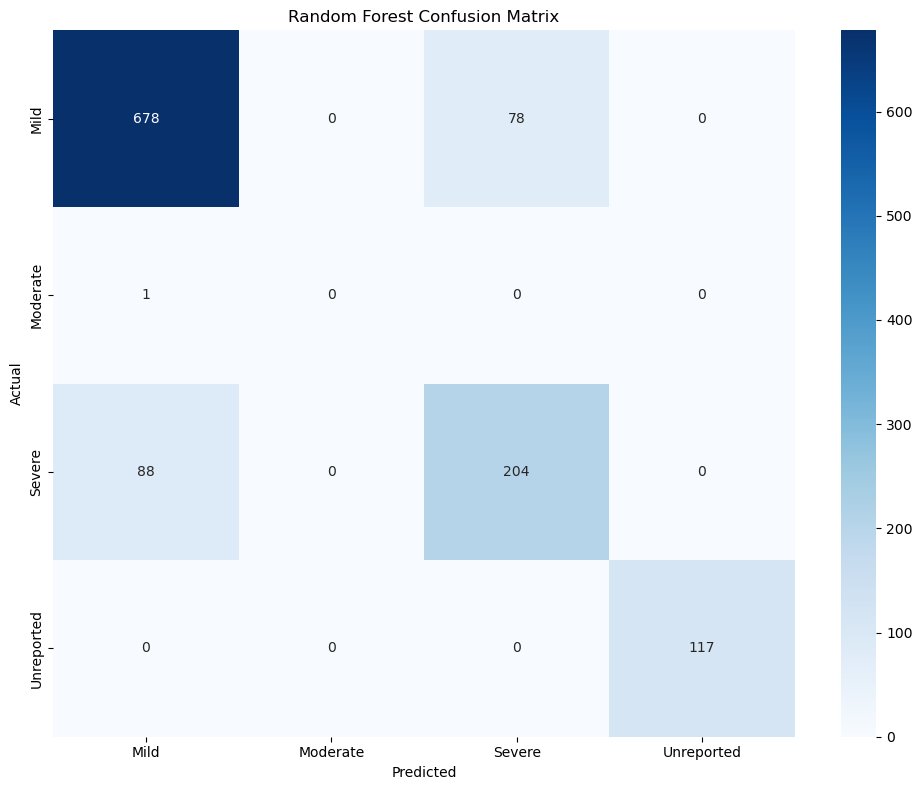

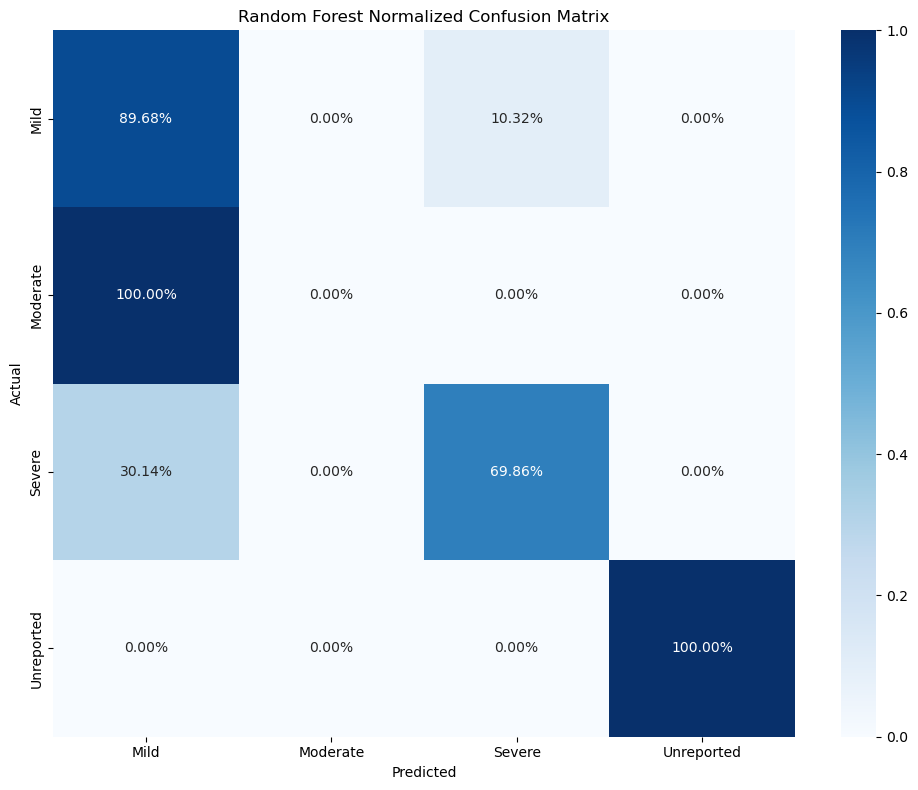


===== Evaluating XGBoost =====
5-Fold CV Accuracy: 0.9429 ± 0.0035
Test Accuracy: 0.8448

Classification Report:
              precision    recall  f1-score   support

        Mild       0.86      0.90      0.88       756
    Moderate       0.00      0.00      0.00         1
      Severe       0.72      0.63      0.67       292
  Unreported       1.00      1.00      1.00       117

    accuracy                           0.84      1166
   macro avg       0.65      0.63      0.64      1166
weighted avg       0.84      0.84      0.84      1166



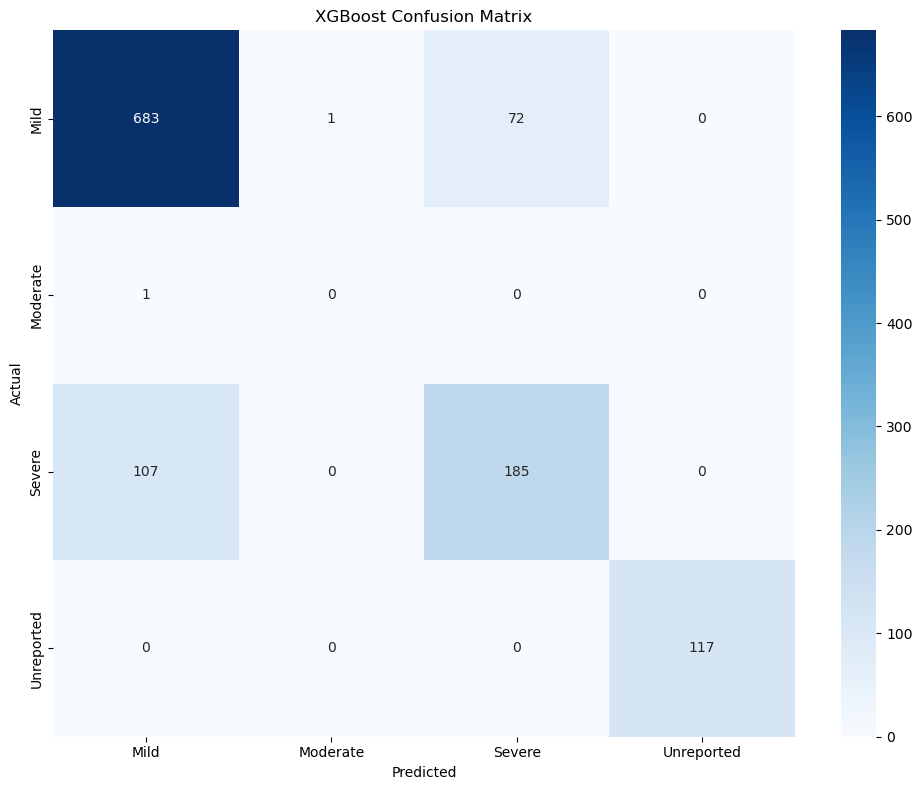

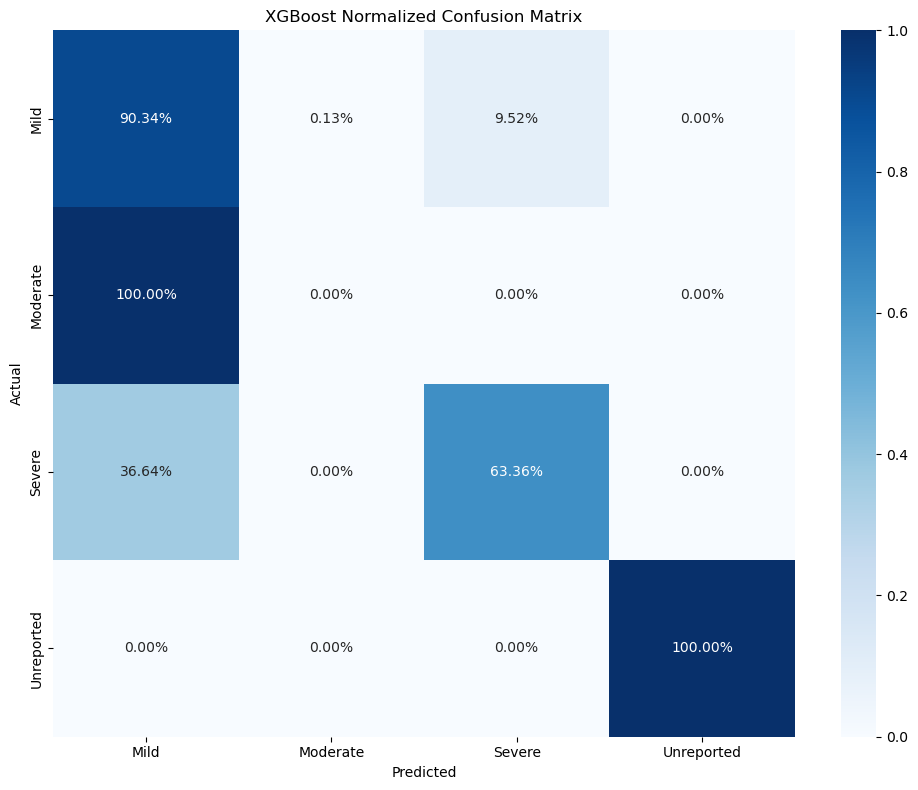


===== Evaluating LightGBM =====
5-Fold CV Accuracy: 0.9437 ± 0.0037
Test Accuracy: 0.8456

Classification Report:
              precision    recall  f1-score   support

        Mild       0.86      0.91      0.88       756
    Moderate       0.00      0.00      0.00         1
      Severe       0.73      0.63      0.68       292
  Unreported       1.00      1.00      1.00       117

    accuracy                           0.85      1166
   macro avg       0.65      0.63      0.64      1166
weighted avg       0.84      0.85      0.84      1166



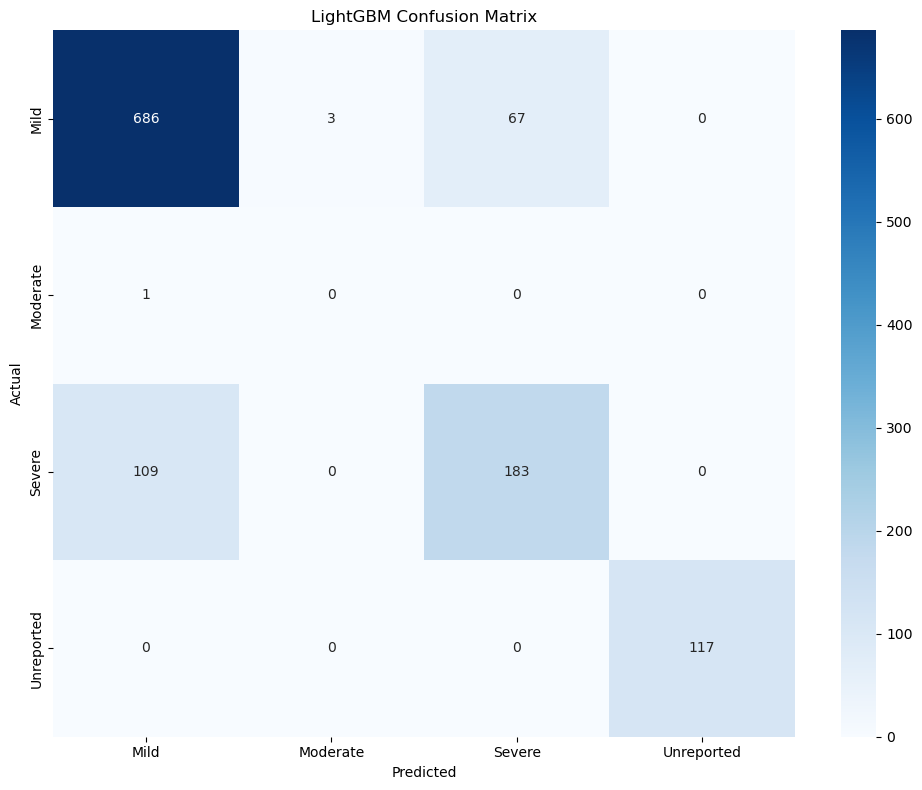

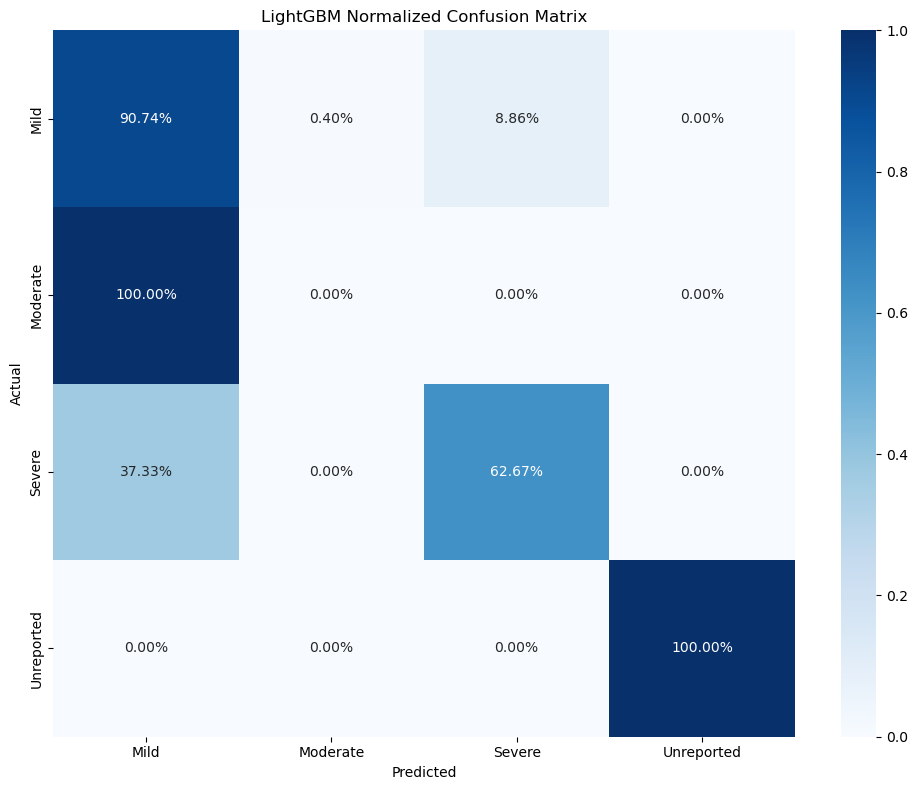


===== Evaluating SVM =====
5-Fold CV Accuracy: 0.8706 ± 0.0069
Test Accuracy: 0.7822

Classification Report:
              precision    recall  f1-score   support

        Mild       0.90      0.75      0.82       756
    Moderate       0.02      1.00      0.05         1
      Severe       0.60      0.77      0.67       292
  Unreported       1.00      1.00      1.00       117

    accuracy                           0.78      1166
   macro avg       0.63      0.88      0.64      1166
weighted avg       0.84      0.78      0.80      1166



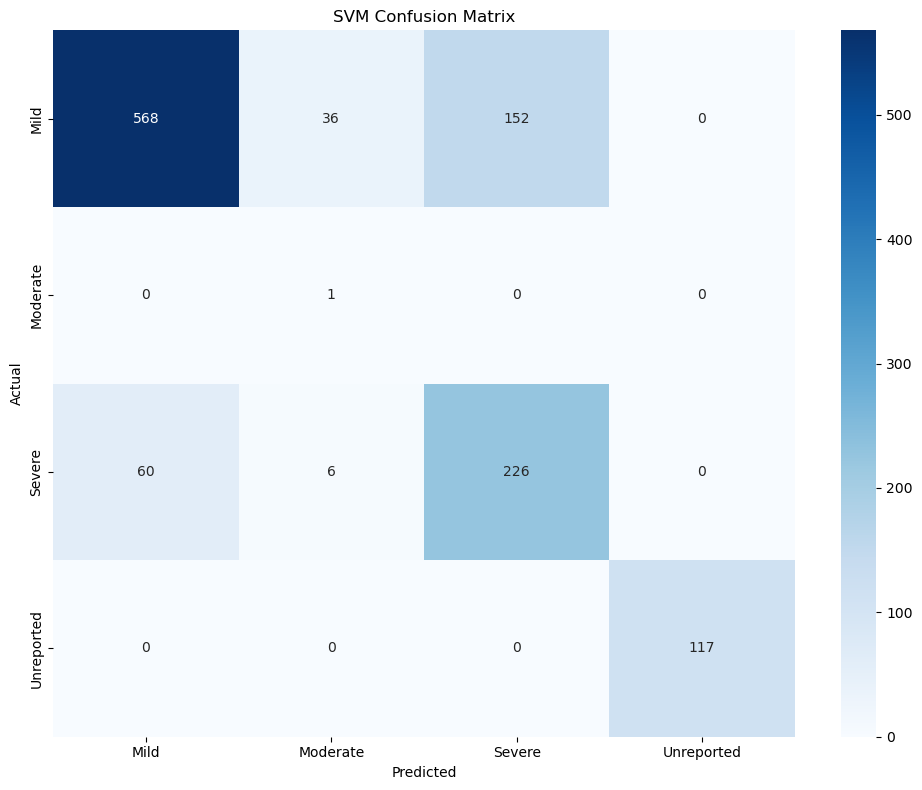

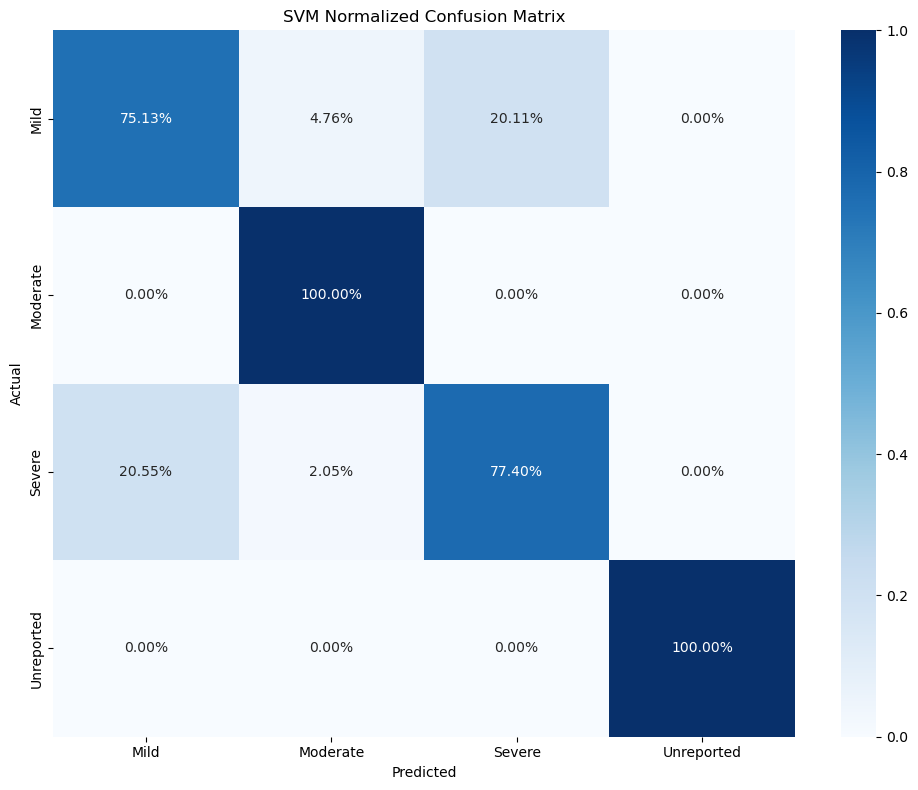


Best performing model: Random Forest with accuracy 0.8568
Model and preprocessing components saved to 'final_improved_bcg_severity_model.pkl'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading and Initial Exploration
print("Loading data...")
try:
    data = pd.read_excel('clean_data_part2.xlsx')
    print(f"Data loaded successfully with {data.shape[0]} rows and {data.shape[1]} columns")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

# Display summary of the dataset
print("\nData summary:")
print(data.info())

# Check the distribution of the target variable
print("\nSeverity distribution:")
print(data['Severity'].value_counts())
print(data['Severity'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))

# 2. Remove leaky features
print("\nRemoving features that could cause data leakage...")
leaky_features = ['Serious', 'Seriousness criteria']
print(f"Removing potentially leaky features: {leaky_features}")

# Check if other suspicious features might need removal
suspicious_terms = ['serious', 'severity', 'seriousness']
for col in data.columns:
    for term in suspicious_terms:
        if term.lower() in str(col).lower() and col not in leaky_features and col != 'Severity':
            print(f"Warning: Potential leaky feature detected: {col}")

# Create a clean dataset without leaky features
data_clean = data.drop(columns=leaky_features)
print(f"Dataset shape after removing leaky features: {data_clean.shape}")

# 3. Split data BEFORE preprocessing (crucial to prevent leakage)
print("\nSplitting data into train and test sets...")
X = data_clean.drop(columns=['Severity'])
y = data_clean['Severity']

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# 4. Handle the class imbalance issue - especially the rare Moderate class
print("\nAnalyzing class imbalance...")
print("Training set class distribution:")
print(y_train.value_counts())

# Check if we even have Moderate cases in train and test
moderate_train = (y_train == 'Moderate').sum()
moderate_test = (y_test == 'Moderate').sum()
print(f"Moderate cases in training set: {moderate_train}")
print(f"Moderate cases in test set: {moderate_test}")

# Given that we only have 7 total moderate cases, suggest a modified approach
if moderate_train < 5:
    print("\nWARNING: Very few Moderate cases available for training.")
    print("Consider a hierarchical approach or merging classes.")
    
    # Option 1: Combine Moderate with Severe (uncomment to use)
    # print("Merging 'Moderate' and 'Severe' classes due to limited Moderate samples...")
    # y_train = y_train.replace('Moderate', 'Severe')
    # y_test = y_test.replace('Moderate', 'Severe')
    
    # Option 2: Hierarchical classification (first Mild vs Non-Mild)
    print("Will implement hierarchical classification (first Mild vs Non-Mild)...")
    # Convert to binary problem first
    y_train_binary = y_train.apply(lambda x: 'Mild' if x == 'Mild' else 'Non-Mild')
    y_test_binary = y_test.apply(lambda x: 'Mild' if x == 'Mild' else 'Non-Mild')
    
    print("Binary class distribution (training set):")
    print(y_train_binary.value_counts())

# 5. Preprocessing (fitted ONLY on training data)
def preprocess_data(df, is_training=True, encoders=None, fill_values=None):
    """
    Preprocess data with proper handling of categorical and numerical features.
    When is_training=True, fit encoders and calculate fill values.
    When is_training=False, apply pre-fitted encoders and fill values.
    """
    df_processed = df.copy()
    
    # Identify numerical and categorical columns
    numerical_cols = df_processed.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    
    if is_training:
        # We're fitting on training data
        encoders = {}
        fill_values = {}
        
        # Calculate fill values for missing numerical data
        for col in numerical_cols:
            median_val = df_processed[col].median()
            df_processed[col] = df_processed[col].fillna(median_val)
            fill_values[col] = median_val
        
        # Calculate fill values and encode categorical features
        for col in categorical_cols:
            # Handle missing values with most frequent value
            mode_val = df_processed[col].mode()[0]
            df_processed[col] = df_processed[col].fillna(mode_val)
            fill_values[col] = mode_val
            
            # Encode categorical variables
            encoder = LabelEncoder()
            df_processed[col] = encoder.fit_transform(df_processed[col])
            encoders[col] = encoder
            
        return df_processed, encoders, fill_values
    else:
        # We're applying to test data
        if not encoders or not fill_values:
            raise ValueError("Encoders and fill_values must be provided for test data")
        
        # Fill missing numerical values
        for col in numerical_cols:
            if col in fill_values:
                df_processed[col] = df_processed[col].fillna(fill_values[col])
        
        # Fill missing categorical values and apply encoding
        for col in categorical_cols:
            if col in fill_values:
                df_processed[col] = df_processed[col].fillna(fill_values[col])
            
            if col in encoders:
                try:
                    df_processed[col] = encoders[col].transform(df_processed[col])
                except ValueError as e:
                    # Handle unseen categories
                    print(f"Warning: Unseen categories in {col}, using fallback")
                    # Create a mask for values not in training data
                    unique_vals = df_processed[col].unique()
                    for val in unique_vals:
                        if val not in encoders[col].classes_:
                            # Replace unseen values with the most frequent value from training
                            most_freq_encoded = encoders[col].transform([fill_values[col]])[0]
                            df_processed.loc[df_processed[col] == val, col] = fill_values[col]
                    
                    # Now transform with all values being valid
                    df_processed[col] = encoders[col].transform(df_processed[col])
        
        return df_processed

# Process training data
print("\nPreprocessing training data...")
X_train_processed, encoders, fill_values = preprocess_data(X_train, is_training=True)

# Process test data using encoders fitted on training
print("Preprocessing test data...")
X_test_processed = preprocess_data(X_test, is_training=False, encoders=encoders, fill_values=fill_values)

# 6. Feature scaling (fitted ONLY on training data)
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

# Convert back to DataFrame for readability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_processed.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_processed.columns)

# 7. Feature selection (using only training data)
print("\nPerforming feature selection...")
selector = RandomForestClassifier(n_estimators=100, random_state=42)

# Choose the appropriate target based on our approach
if 'y_train_binary' in locals():
    # Binary classification first
    selector.fit(X_train_scaled, y_train_binary)
    target_for_selection = y_train_binary
else:
    # Multi-class classification
    selector.fit(X_train_scaled, y_train)
    target_for_selection = y_train

# Plot feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'Importance': selector.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 features by importance:")
print(feature_importance.head(20))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances (After Removing Leaky Features)')
plt.tight_layout()
plt.show()
plt.close()

# Select features based on importance
feature_selector = SelectFromModel(selector, threshold='median')
feature_selector.fit(X_train_scaled, target_for_selection)
selected_features = X_train_processed.columns[feature_selector.get_support()]
print(f"\nSelected {len(selected_features)} features: {selected_features.tolist()}")

# Apply feature selection
X_train_selected = feature_selector.transform(X_train_scaled)
X_test_selected = feature_selector.transform(X_test_scaled)

# 8. Handling class imbalance with SMOTE (only on training data)
print("\nApplying SMOTE to balance classes...")

# Encode target variables for SMOTE
target_encoder = LabelEncoder()

if 'y_train_binary' in locals():
    # Binary classification
    target_encoder.fit(pd.concat([y_train_binary, y_test_binary]))
    y_train_encoded = target_encoder.transform(y_train_binary)
    y_test_encoded = target_encoder.transform(y_test_binary)
else:
    # Multi-class classification
    target_encoder.fit(pd.concat([y_train, y_test]))
    y_train_encoded = target_encoder.transform(y_train)
    y_test_encoded = target_encoder.transform(y_test)

print("Original encoded class distribution:")
unique, counts = np.unique(y_train_encoded, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train_encoded)

print("\nAfter SMOTE, encoded class distribution:")
unique, counts = np.unique(y_train_smote, return_counts=True)
for u, c in zip(unique, counts):
    if 'y_train_binary' in locals():
        # Binary case
        class_name = target_encoder.inverse_transform([u])[0]
    else:
        # Multi-class case
        class_name = target_encoder.inverse_transform([u])[0]
    print(f"Class {u} ({class_name}): {c} samples")

# 9. Model Training and Evaluation with Cross Validation
print("\n========== MODEL TRAINING AND EVALUATION ==========")

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, class_names=None):
    """Train and evaluate model with cross-validation and proper metrics"""
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    print(f"\n===== Evaluating {model_name} =====")
    print(f"5-Fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Train on full training data
    model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    if class_names is not None:
        print(classification_report(y_test, y_pred, target_names=class_names))
    else:
        print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    if class_names is not None:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, 
                   yticklabels=class_names)
    else:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Normalized confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    if class_names is not None:
        sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', 
                   xticklabels=class_names, 
                   yticklabels=class_names)
    else:
        sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues')
    plt.title(f'{model_name} Normalized Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return model, accuracy

# Define models to evaluate
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'SVM': SVC(probability=True, random_state=42)
}

# Get appropriate class names based on our approach
if 'y_train_binary' in locals():
    # Binary classification
    class_names = target_encoder.classes_
    print("\nTraining binary classification models (Mild vs Non-Mild)...")
else:
    # Multi-class classification
    class_names = target_encoder.classes_
    print("\nTraining multi-class classification models...")

# Train and evaluate each model
results = {}
for name, model in models.items():
    try:
        trained_model, accuracy = evaluate_model(
            model, X_train_smote, y_train_smote, 
            X_test_selected, y_test_encoded,
            name, class_names
        )
        results[name] = {'model': trained_model, 'accuracy': accuracy}
    except Exception as e:
        print(f"Error evaluating {name}: {e}")

# 10. Identify the best model
if results:
    best_model_name = max(results, key=lambda x: results[x]['accuracy'])
    print(f"\nBest performing model: {best_model_name} with accuracy {results[best_model_name]['accuracy']:.4f}")
    
    # Save the best model along with preprocessing components
    import pickle
    with open('final_improved_bcg_severity_model.pkl', 'wb') as f:
        pickle.dump({
            'model': results[best_model_name]['model'],
            'encoders': encoders,
            'fill_values': fill_values,
            'scaler': scaler,
            'feature_selector': feature_selector,
            'target_encoder': target_encoder,
            'selected_features': selected_features.tolist(),
            'is_binary': 'y_train_binary' in locals()
        }, f)
    print("Model and preprocessing components saved to 'final_improved_bcg_severity_model.pkl'")

# 11. Hierarchical classification (if binary was used first)
if 'y_train_binary' in locals():
    print("\n========== STAGE 2: NON-MILD SUBCLASSIFICATION ==========")
    
    # Get indices of Non-Mild samples in the training set
    non_mild_indices_train = y_train_binary == 'Non-Mild'
    X_train_non_mild = X_train_selected[non_mild_indices_train]
    y_train_non_mild = y_train[non_mild_indices_train]
    
    # Encode Non-Mild classes
    non_mild_encoder = LabelEncoder()
    non_mild_encoder.fit(y_train_non_mild)
    y_train_non_mild_encoded = non_mild_encoder.transform(y_train_non_mild)
    
    print("Non-Mild class distribution (training):")
    print(y_train_non_mild.value_counts())
    
    # Apply SMOTE to balance Non-Mild classes
    if len(non_mild_encoder.classes_) > 1:  # Only if we have multiple classes
        smote_non_mild = SMOTE(random_state=42)
        X_train_non_mild_smote, y_train_non_mild_smote = smote_non_mild.fit_resample(
            X_train_non_mild, y_train_non_mild_encoded
        )
        
        print("\nAfter SMOTE, Non-Mild class distribution:")
        unique, counts = np.unique(y_train_non_mild_smote, return_counts=True)
        for u, c in zip(unique, counts):
            class_name = non_mild_encoder.inverse_transform([u])[0]
            print(f"Class {u} ({class_name}): {c} samples")
    
    # Get indices of Non-Mild samples in the test set
    non_mild_indices_test = y_test_binary == 'Non-Mild'
    X_test_non_mild = X_test_selected[non_mild_indices_test]
    y_test_non_mild = y_test[non_mild_indices_test]
    y_test_non_mild_encoded = non_mild_encoder.transform(y_test_non_mild)
    
    # Train models for Non-Mild subclassification
    non_mild_models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(random_state=42),
        'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    }
    
    # Train and evaluate Non-Mild subclassification models
    non_mild_results = {}
    for name, model in non_mild_models.items():
        try:
            trained_model, accuracy = evaluate_model(
                model, X_train_non_mild_smote, y_train_non_mild_smote, 
                X_test_non_mild, y_test_non_mild_encoded,
                f"{name} (Non-Mild)", non_mild_encoder.classes_
            )
            non_mild_results[name] = {'model': trained_model, 'accuracy': accuracy}
        except Exception as e:
            print(f"Error evaluating {name} for Non-Mild: {e}")
    
    # Identify the best Non-Mild subclassification model
    if non_mild_results:
        best_non_mild_model_name = max(non_mild_results, key=lambda x: non_mild_results[x]['accuracy'])
        print(f"\nBest performing Non-Mild subclassification model: {best_non_mild_model_name} with accuracy {non_mild_results[best_non_mild_model_name]['accuracy']:.4f}")
        
        # Save the hierarchical models together
        with open('hierarchical_bcg_severity_model.pkl', 'wb') as f:
            pickle.dump({
                'binary_model': results[best_model_name]['model'],
                'non_mild_model': non_mild_results[best_non_mild_model_name]['model'],
                'encoders': encoders,
                'fill_values': fill_values,
                'scaler': scaler,
                'feature_selector': feature_selector,
                'binary_target_encoder': target_encoder,
                'non_mild_encoder': non_mild_encoder,
                'selected_features': selected_features.tolist()
            }, f)
        print("Hierarchical model saved to 'hierarchical_bcg_severity_model.pkl'")

# 12. Final Deployment Function
def predict_severity_for_webapp(patient_data, model_path='final_improved_bcg_severity_model.pkl'):
    """
    Predicts BCG vaccination adverse effects severity for new patients from web app input.
    
    Args:
        patient_data (dict): Dictionary containing patient information from web form
        model_path (str): Path to the saved model file
    
    Returns:
        dict: Prediction results including severity and confidence
    """
    import pickle
    import pandas as pd
    import numpy as np
    
    # Load the model and preprocessing components
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
    
    # Extract components
    model = model_data['model']
    encoders = model_data['encoders']
    fill_values = model_data['fill_values']
    scaler = model_data['scaler']
    feature_selector = model_data['feature_selector']
    target_encoder = model_data['target_encoder']
    selected_features = model_data['selected_features']
    is_binary = model_data.get('is_binary', False)
    
    # Ensure all required fields are present in the input
    required_fields = selected_features
    
    # Create a complete patient data dict with all fields needed by model
    complete_patient_data = {}
    
    # Fill in with data from user input where available
    for field in required_fields:
        if field in patient_data and patient_data[field] is not None:
            complete_patient_data[field] = patient_data[field]
        else:
            # Use fill values from training for missing fields
            if field in fill_values:
                complete_patient_data[field] = fill_values[field]
            else:
                # For numeric fields, use a reasonable default
                if field == 'Age/Years':
                    complete_patient_data[field] = 0
                else:
                    complete_patient_data[field] = 'Unknown'
    
    # Convert patient data to DataFrame
    patient_df = pd.DataFrame([complete_patient_data])
    
    # Check for hierarchical model
    if 'non_mild_model' in model_data:
        # This is a hierarchical model
        binary_model = model_data['binary_model']
        non_mild_model = model_data['non_mild_model']
        binary_target_encoder = model_data['binary_target_encoder']
        non_mild_encoder = model_data['non_mild_encoder']
        
        # Preprocess data
        patient_processed = preprocess_data(patient_df, is_training=False, 
                                           encoders=encoders, 
                                           fill_values=fill_values)
        
        # Scale features
        patient_scaled = scaler.transform(patient_processed)
        
        # Apply feature selection
        patient_selected = feature_selector.transform(patient_scaled)
        
        # First-stage prediction (Mild vs Non-Mild)
        binary_pred = binary_model.predict(patient_selected)[0]
        binary_probs = binary_model.predict_proba(patient_selected)[0]
        
        # Map to class names
        binary_class = binary_target_encoder.inverse_transform([binary_pred])[0]
        
        if binary_class == 'Mild':
            # If prediction is Mild, we're done
            severity_label = 'Mild'
            confidence = binary_probs[binary_pred]
            result = {
                'predicted_severity': severity_label,
                'confidence': float(confidence),
                'probabilities': {
                    'Mild': float(binary_probs[binary_target_encoder.transform(['Mild'])[0]]),
                    'Non-Mild': float(binary_probs[binary_target_encoder.transform(['Non-Mild'])[0]])
                }
            }
        else:
            # If Non-Mild, predict specific class
            non_mild_pred = non_mild_model.predict(patient_selected)[0]
            non_mild_probs = non_mild_model.predict_proba(patient_selected)[0]
            
            # Get specific severity class
            severity_label = non_mild_encoder.inverse_transform([non_mild_pred])[0]
            confidence = non_mild_probs[non_mild_pred]
            
            # Combine probabilities from both models
            result = {
                'predicted_severity': severity_label,
                'confidence': float(confidence),
                'probabilities': {
                    'Mild': float(binary_probs[binary_target_encoder.transform(['Mild'])[0]])
                }
            }
            
            # Add probabilities for non-mild classes
            for i, cls in enumerate(non_mild_encoder.classes_):
                result['probabilities'][cls] = float(non_mild_probs[i] * 
                  binary_probs[binary_target_encoder.transform(['Non-Mild'])[0]])
    else:
        # Standard model
        # Preprocess data
        patient_processed = preprocess_data(patient_df, is_training=False, 
                                          encoders=encoders, 
                                          fill_values=fill_values)
        
        # Scale features
        patient_scaled = scaler.transform(patient_processed)
        
        # Apply feature selection
        patient_selected = feature_selector.transform(patient_scaled)
        
        # Make prediction
        severity_pred = model.predict(patient_selected)[0]
        severity_probs = model.predict_proba(patient_selected)[0]
        
        # Map to class name
        severity_label = target_encoder.inverse_transform([severity_pred])[0]
        
        # If binary model, map to actual severity classes based on context
        if is_binary and severity_label == 'Non-Mild':
            severity_label = "Severe (default Non-Mild class)"
        
        # Prepare result
        result = {
            'predicted_severity': severity_label,
            'confidence': float(severity_probs[severity_pred]),
            'probabilities': {
                target_encoder.inverse_transform([i])[0]: float(prob)
                for i, prob in enumerate(severity_probs)
            }
        }
    
    # Add monitoring recommendations based on severity
    monitoring_recommendations = {
        'Mild': 'Routine observation, no special monitoring required',
        'Moderate': 'Regular follow-up within 48 hours, monitor for progression',
        'Severe': 'Immediate attention required, close monitoring and intervention',
        'Unreported': 'Detailed assessment needed to determine severity',
        'Non-Mild': 'Close monitoring required, specific severity unclear'
    }
    
    result['recommended_monitoring'] = monitoring_recommendations.get(
        severity_label, 'Close monitoring recommended'
    )
    
    return result